# Imports

In [1]:
from os.path import join, abspath, isfile, dirname
import sys
from astropy import units as u
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from typing import List, Tuple
from scipy.stats import ttest_rel, wilcoxon
%load_ext autoreload
%autoreload 2

In [2]:
__file__ = "st_new_distance.ipynb"
data_dir = join(dirname(dirname(abspath(__file__))),"data")

sys.path.append(join(dirname(dirname(abspath(__file__))), "src"))

In [3]:
from transforms import Rotation
from voting_algorithm import VotingAlgorithm
from star_metric import StarMetric
from alg_utils import vector_angle
from logger import Logger, LogData
from analyzer import plot_typography

# Initialization

In [4]:
plot_typography(usetex=True, small=12, medium=16, big=18)

## Constants

In [133]:
# NUM_EXPERIMENTS = 50
# NUM_STARS = 2#75
# NOISE_STD_SCALES = [0.1, 0.5, 1, 5, 10] # in pixels
NUM_BINS = 100
NOISE_STD = 0.1
W = 0
OFFSET = 3.3e-4#3.3e-4
angle_lut = f"angle_est_std_{NOISE_STD}"
gamma_lut = f"gamma_est_std_{NOISE_STD}"


# tinker around with these to check whether the real stars are found
# this will be a clear trade-off (everything found = many stars)
K = 0
EPS = 2.6e-4
EPS_ANGLE = 3.5e-4

SQRT_POW = 0.75


In [6]:
np.random.seed(42)

## Objects

In [7]:
sm = StarMetric()

# setup logger
logger = sm.logger

C:\Users\rpatr\Documents\GitHub\adcs-simulation\src\transforms.py:57: RuntimeWarning: invalid value encountered in sqrt
  one_minus_cos_inv_sqrt = np.sqrt(1. / (1. - cos_angle))
C:\Users\rpatr\Documents\GitHub\adcs-simulation\src\transforms.py:61: RuntimeWarning: invalid value encountered in sqrt
  axis_z = one_minus_cos_inv_sqrt * np.sqrt(matrix[2, 2] - cos_angle) * np.sign(mat_10_01)


In [8]:
logger.load("time_log_2021-01-09 23_32_30", decimate_step=100)
sm.discretize_logger_magnitude()

In [9]:
len(logger.id1.data)

200

# Ground truth calculation

In [ ]:
# calculate the L2 distance between star pairs on the sensor

# distances = []
distance_ratios = []

for i in range(len(df_pairs)):
    
    # extract star coordinates of the pair
    star1 = df.loc[int(df_pairs.loc[i].id1)][["x", "y", "z"]].to_numpy()
    star2 = df.loc[int(df_pairs.loc[i].id2)][["x", "y", "z"]].to_numpy()
    

    # calculate sin-like quantity
    distance_ratios.append(sm.calc_ground_truth(star1, star2))
    
    
# append column
# df_pairs["distance_ratio"] = distance_ratios

In [23]:
# save file
df_pairs.to_csv(join(data_dir, "star_pairs_max_90_deg_with_distance.tsv"), sep="\t")

# Histograms

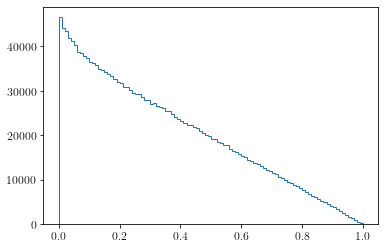

In [111]:
cos_angle_hist = plt.hist(1-np.cos(sm.df_pairs.angle)**SQRT_POW, bins=NUM_BINS, histtype="step", label=r"$\cos\phi$")
# plt.ylim([0, 35000])

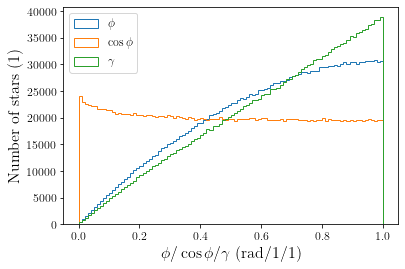

In [12]:
angle_hist = plt.hist(sm.df_pairs.angle/(np.pi/2), bins=NUM_BINS, histtype="step", label=r"$\phi$")
cos_angle_hist = plt.hist(1-np.cos(sm.df_pairs.angle), bins=NUM_BINS, histtype="step", label=r"$\cos\phi$")
gamma_hist = plt.hist(sm.df_pairs.distance_ratio/np.sqrt(2), bins=NUM_BINS, histtype="step", label=r"$\gamma$")
plt.legend()
plt.xlabel(r"$\phi/\cos\phi/\gamma\ (\mathrm{rad}/1/1)$")
plt.ylabel("Number of stars (1)")
plt.legend(loc="upper left")
plt.savefig("hist.png")

# DB queries

(array([ 3., 10., 37., 36., 36., 29., 23., 15.,  9.,  2.]),
 array([ 932. ,  967.6, 1003.2, 1038.8, 1074.4, 1110. , 1145.6, 1181.2,
        1216.8, 1252.4, 1288. ]),
 <a list of 10 Patch objects>)

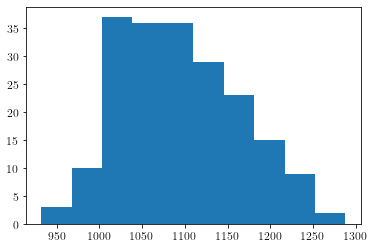

In [178]:
plt.hist(z_old)

(array([ 6.,  9., 10., 15., 20., 27., 23., 20., 15., 55.]),
 array([  30. ,  137.2,  244.4,  351.6,  458.8,  566. ,  673.2,  780.4,
         887.6,  994.8, 1102. ]),
 <a list of 10 Patch objects>)

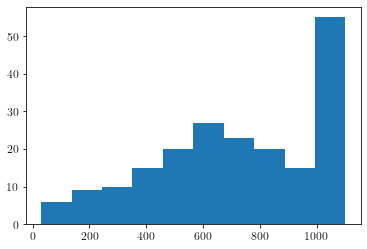

In [179]:
plt.hist(z2)

Text(0, 0.5, 'Relative decrease (\\%)')

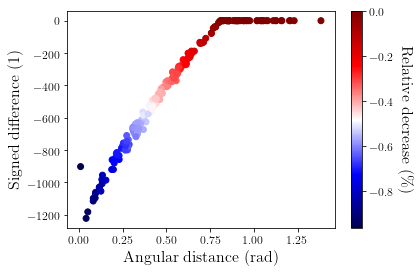

In [180]:
plt.scatter(logger.angle_gt.data, z2-z_old, c=(z2-z_old)/z_old, cmap="seismic")
# plt.title("Difference of star pairs between information fusion and the standard metric")
plt.xlabel("Angular distance (rad)")
plt.ylabel("Signed difference (1)")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Relative decrease (\%)", rotation=270)

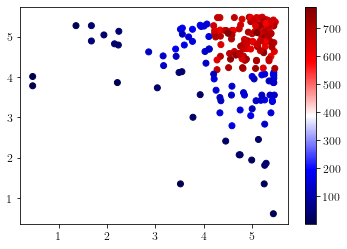

In [187]:
c = plt.scatter(logger.mag1.data, logger.mag2.data, marker="o", c=z_old_mag, cmap="seismic")
plt.colorbar()

Text(0, 0.5, 'Signed difference (1)')

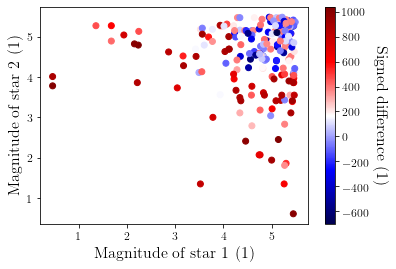

In [188]:
# plt.scatter(logger.mag1.data, logger.mag2.data, marker="x",c=z2_mag-z_old_mag, cmap="jet")
c = plt.scatter(logger.mag1.data, logger.mag2.data, marker="o", c=z2-z_old_mag, cmap="seismic")
plt.xlabel("Magnitude of star 1 (1)")
plt.ylabel("Magnitude of star 2 (1)")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Signed difference (1)", rotation=270)

In [13]:
z_old = sm.z_old(noise_std=NOISE_STD, eps=EPS)
# z_old_filtered = sm.z_old_filtered(noise_std=NOISE_STD, eps=EPS)
z_old_mag = sm.z_old_mag(noise_std=NOISE_STD, eps=EPS)

In [14]:
z_new2 = sm.z_new2(noise_std=NOISE_STD, k=K, w=W, offset=OFFSET)
z_new2_filtered = sm.z_new2_filtered(noise_std=NOISE_STD, k=K, w=W, offset=OFFSET)
# z_new2_mag = sm.z_new2_mag(noise_std=NOISE_STD, k=K, w=W, offset=OFFSET)
z2 = sm.z2(noise_std=NOISE_STD, k=K, w=W, offset=OFFSET, eps=EPS)
# z2_mag = sm.z2_mag(noise_std=NOISE_STD, k=K, w=W, offset=OFFSET, eps=EPS)

In [1116]:
(z_old_filtered==0).sum(),  (z_new2_filtered==0).sum()

(13, 20)

In [15]:
ref = lambda gt, est: np.abs(gt-est)
meas = lambda est: K*(np.abs(np.sqrt(2)-est)**W)+OFFSET
gamma2cos = lambda gamma: 1-gamma**2/2

In [16]:
gamma_query = np.array([ref(gt, d) for (gt,d) in zip(logger.gamma_gt.data, logger.__dict__["gamma_est_std_0.1"].data)])
gamma_bound = np.array([meas(d) for d in logger.__dict__["gamma_est_std_0.1"].data])

In [17]:
g2 = np.array([ref(gt, d) for (gt,d) in zip(logger.gamma_gt.data, logger.__dict__["gamma_est_std_0.5"].data)])
g3 = np.array([ref(gt, d) for (gt,d) in zip(logger.gamma_gt.data, logger.__dict__["gamma_est_std_1"].data)])
g4 = np.array([ref(gt, d) for (gt,d) in zip(logger.gamma_gt.data, logger.__dict__["gamma_est_std_5"].data)])
g5 = np.array([ref(gt, d) for (gt,d) in zip(logger.gamma_gt.data, logger.__dict__["gamma_est_std_10"].data)])

0

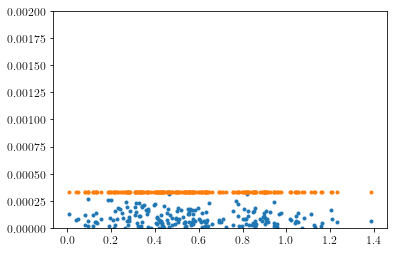

In [18]:
plt.scatter(logger.angle_gt.data, gamma_query, marker=".")
plt.scatter(logger.angle_gt.data, gamma_bound, marker=".")
plt.ylim([0, 0.002])
(gamma_query > gamma_bound).sum()

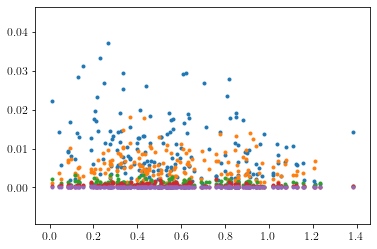

In [19]:
plt.scatter(logger.angle_gt.data, g5, marker=".")
plt.scatter(logger.angle_gt.data, g4, marker=".")
plt.scatter(logger.angle_gt.data, g3, marker=".")
plt.scatter(logger.angle_gt.data, g2, marker=".")
plt.scatter(logger.angle_gt.data, gamma_query, marker=".")


(array([43., 43., 37., 16., 23., 18.,  8.,  7.,  3.,  2.]),
 array([1.11519480e-06, 3.27446911e-05, 6.43741874e-05, 9.60036838e-05,
        1.27633180e-04, 1.59262676e-04, 1.90892173e-04, 2.22521669e-04,
        2.54151165e-04, 2.85780662e-04, 3.17410158e-04]),
 <a list of 10 Patch objects>)

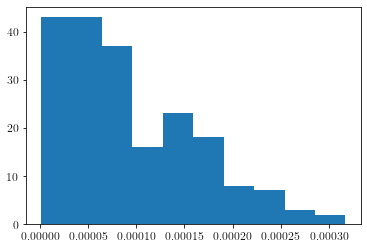

In [20]:
plt.hist(gamma_query)

In [21]:
cos_query = np.array([ref(np.cos(gt), np.cos(d)) for (gt,d) in zip(logger.angle_gt.data, logger.__dict__["angle_est_std_0.1"].data)])
c2 = np.array([ref(np.cos(gt), np.cos(d)) for (gt,d) in zip(logger.angle_gt.data, logger.__dict__["angle_est_std_0.5"].data)])
c3 = np.array([ref(np.cos(gt), np.cos(d)) for (gt,d) in zip(logger.angle_gt.data, logger.__dict__["angle_est_std_1"].data)])
c4 = np.array([ref(np.cos(gt), np.cos(d)) for (gt,d) in zip(logger.angle_gt.data, logger.__dict__["angle_est_std_5"].data)])
c5 = np.array([ref(np.cos(gt), np.cos(d)) for (gt,d) in zip(logger.angle_gt.data, logger.__dict__["angle_est_std_10"].data)])

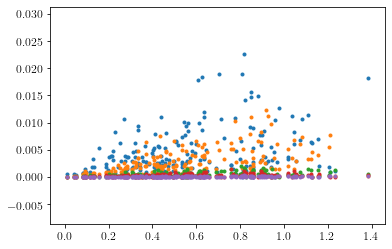

In [22]:
plt.scatter(logger.angle_gt.data, c5, marker=".")
plt.scatter(logger.angle_gt.data, c4, marker=".")
plt.scatter(logger.angle_gt.data, c3, marker=".")
plt.scatter(logger.angle_gt.data, c2, marker=".")
plt.scatter(logger.angle_gt.data, cos_query, marker=".")

0

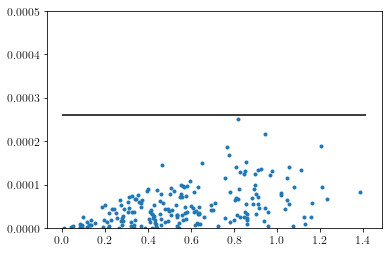

In [23]:
plt.scatter(logger.angle_gt.data, cos_query, marker=".")
plt.hlines(EPS, 0, np.sqrt(2))
plt.ylim([0, 0.0005])
(cos_query > EPS).sum()

In [24]:
gamma_cos_query = np.array([ref(np.cos(gt), d) for (gt,d) in zip(logger.angle_gt.data,
                                                 [gamma2cos(g) for g in logger.__dict__["gamma_est_std_10"].data])])

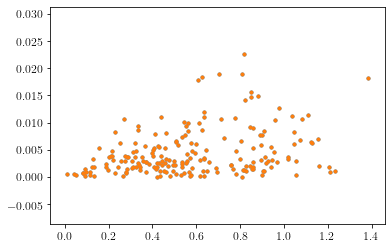

In [25]:
plt.scatter(logger.angle_gt.data, c5, marker=".")
plt.scatter(logger.angle_gt.data, gamma_cos_query, marker=".")

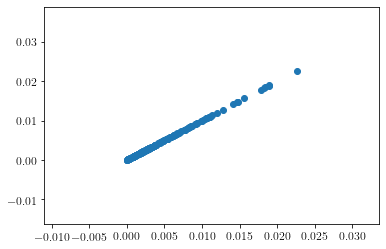

In [26]:
plt.scatter(c5,gamma_cos_query)

(array([ 2., 12.,  2., 39.,  2., 71., 52.,  1., 17.,  2.]),
 array([-3.33066907e-16, -2.66453526e-16, -1.99840144e-16, -1.33226763e-16,
        -6.66133815e-17,  0.00000000e+00,  6.66133815e-17,  1.33226763e-16,
         1.99840144e-16,  2.66453526e-16,  3.33066907e-16]),
 <a list of 10 Patch objects>)

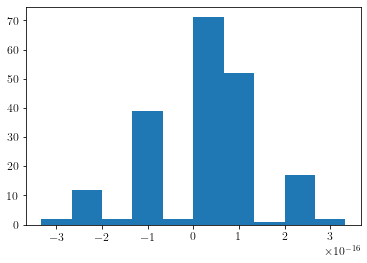

In [27]:
plt.hist(gamma_cos_query-c5)

In [28]:
z4 = np.array([len(
        sm.df_in_fov.loc[(np.abs(sm.cos_angle-np.cos(angle))<EPS) &
                      (np.abs(sm.cos_angle-(1-dist**2/2))<EPS)]
        )
      for angle, dist in zip(logger.__dict__[f"angle_est_std_0.1"].data, logger.__dict__[f"gamma_est_std_0.1"].data)])

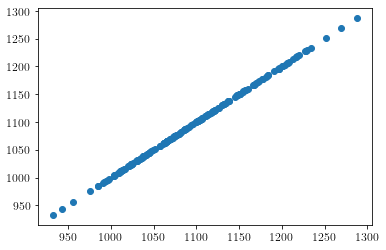

In [29]:
plt.scatter(z_old, z4)

In [30]:
angle_query = np.array([ref(gt, d) for (gt,d) in zip(logger.angle_gt.data, logger.__dict__["angle_est_std_0.1"].data)])

0

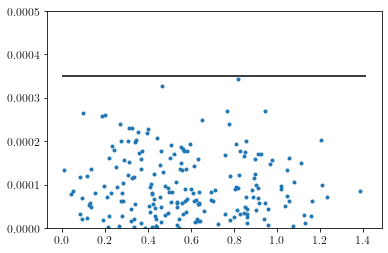

In [31]:
plt.scatter(logger.angle_gt.data, angle_query, marker=".")
plt.hlines(EPS_ANGLE, 0, np.sqrt(2))
plt.ylim([0, 0.0005])
(cos_query > EPS).sum()

In [32]:
z_angle = sm.z_angle(eps=EPS_ANGLE, noise_std=NOISE_STD)

In [134]:
sqrt_cos_query = np.array([ref(np.cos(gt)**SQRT_POW, np.cos(d)**SQRT_POW) for (gt,d) in zip(logger.angle_gt.data, logger.__dict__["angle_est_std_0.1"].data)])

0 0.00020619150143486031


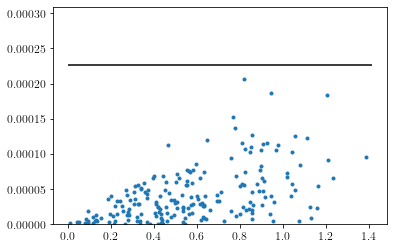

In [135]:
EPS_SQRT = sqrt_cos_query.max()*1.1
plt.scatter(logger.angle_gt.data, sqrt_cos_query, marker=".")
plt.hlines(EPS_SQRT, 0, np.sqrt(2))
plt.ylim([0, sqrt_cos_query.max()*1.5])
print((sqrt_cos_query > EPS_SQRT).sum(), sqrt_cos_query.max())

In [136]:
z_sqrt_cos = np.array([len(sm.df_in_fov.loc[(np.abs(np.cos(sm.df_in_fov.angle)**SQRT_POW - np.cos(angle)**SQRT_POW) < EPS_SQRT)]) for angle in
                         sm.logger.__dict__[f"angle_est_std_{NOISE_STD}"].data])

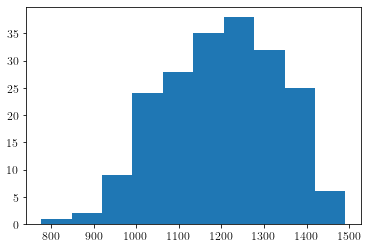

In [137]:
_ = plt.hist(z_sqrt_cos)

Text(0.5, 0, 'Angular distance (rad)')

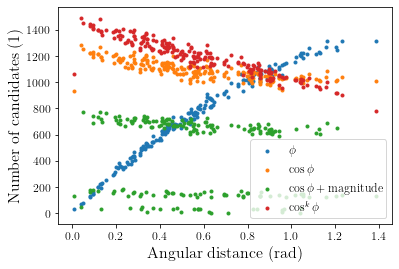

In [138]:
plt.scatter(logger.angle_gt.data, z_angle, marker=".", label=r"$\phi$")
plt.scatter(logger.angle_gt.data, z_old, marker=".", label=r"$\cos\phi$")
plt.scatter(logger.angle_gt.data, z_old_mag, marker=".", label=r"$\cos\phi + \mathrm{magnitude}$")
# plt.scatter(logger.angle_gt.data, z2, marker=".")
# plt.scatter(logger.angle_gt.data, z_new2, marker=".")
plt.scatter(logger.angle_gt.data, z_sqrt_cos, marker=".", label=r"$\cos^k\phi$")
plt.legend()
plt.ylabel(r"Number of candidates (1)")
plt.xlabel("Angular distance (rad)")
# plt.savefig("candidate_comparison.png")

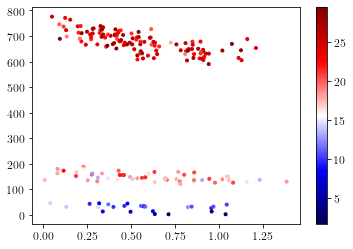

In [71]:
plt.scatter(logger.angle_gt.data, z_old_mag, marker=".", label=r"$\cos\phi + \mathrm{magnitude}$", c=logger.mag1.data*logger.mag2.data, cmap="seismic")
plt.colorbar()

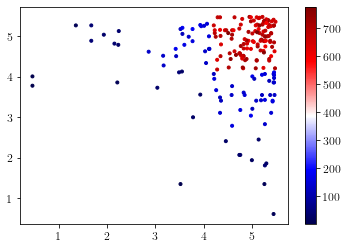

In [72]:
plt.scatter(logger.mag1.data, logger.mag2.data, marker=".", label=r"$\cos\phi + \mathrm{magnitude}$", c=z_old_mag, cmap="seismic")
plt.colorbar()

Text(0, 0.5, 'Signed difference (1)')

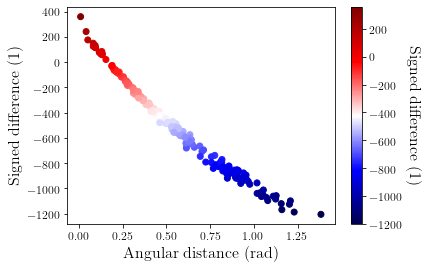

In [67]:
plt.scatter(logger.angle_gt.data, z_sqrt_cos-z_angle, c=(z_sqrt_cos-z_angle), cmap="seismic")
# plt.title("Difference of star pairs between information fusion and the standard metric")
plt.xlabel("Angular distance (rad)")
plt.ylabel("Signed difference (1)")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Signed difference (1)", rotation=270)

Text(0, 0.5, 'Signed difference (1)')

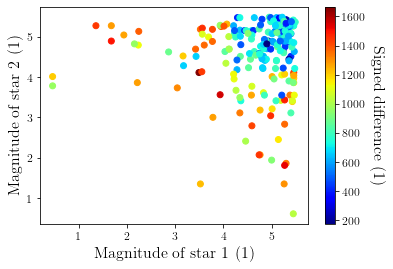

In [132]:
c = plt.scatter(logger.mag1.data, logger.mag2.data, marker="o", c=(z_sqrt_cos-z_old_mag), cmap="jet")
plt.xlabel("Magnitude of star 1 (1)")
plt.ylabel("Magnitude of star 2 (1)")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Signed difference (1)", rotation=270)
# plt.savefig("st_scatter_z_sqrt_cos_z_old_mag.png", bbox_inches='tight')

In [440]:
# z_new3 = np.array([len(sm.df_in_fov.loc[(np.abs(sm.df_in_fov.distance_ratio-dist)<k/(1.5+30*dist))])
#              for dist, star1, star2 in zip(logger.__dict__[gamma_query].data, logger.id1.data, logger.id2.data)])

# z_new3_filtered = np.array([len(sm.df_in_fov.loc[(np.abs(sm.df_in_fov.distance_ratio-dist)<k/(1.5+30*dist))]) 
#          if len(sm.df_in_fov.loc[
#                  (sm.df_in_fov.id1==star1) & 
#                  (sm.df_in_fov.id2==star2) &    
#                  (np.abs(sm.df_in_fov.distance_ratio-dist)<k/(1.5+30*dist))                 
#              ])!=0 
#          else 0 
#          for dist, star1, star2 in zip(logger.__dict__[gamma_query].data, logger.id1.data, logger.id2.data)])

# z3 = np.array([len(
#         sm.df_in_fov.loc[(np.abs(sm.cos_angle-np.cos(angle))<eps) &
#                       (np.abs(sm.df_in_fov.distance_ratio-dist)<k/(1.5+30*dist))
#                      ]
#         )
#       for angle, dist in zip(logger.__dict__[angle_query].data, logger.__dict__[gamma_query].data)])
# np.array(z_new3_filtered==0).sum()

# Significance tests

In [28]:
wilcoxon(z_old, z2, zero_method="pratt", alternative="greater") # H0: median is negative

WilcoxonResult(statistic=20100.0, pvalue=7.167798061353408e-35)

In [29]:
wilcoxon(z_old_mag, z2_mag, zero_method="pratt", alternative="greater")

WilcoxonResult(statistic=20100.0, pvalue=7.164467193422552e-35)

In [30]:
wilcoxon(z_old_mag, z2, zero_method="pratt", alternative="greater") # H0 can be rejected, even if there is no split by magnitude product

WilcoxonResult(statistic=18769.0, pvalue=9.842472273558768e-27)

In [31]:
wilcoxon(z_old_mag, z2, zero_method="pratt", correction=False, alternative="less") # H0 cannot be rejected with eps = 0.05

WilcoxonResult(statistic=18769.0, pvalue=1.0)

# Plots

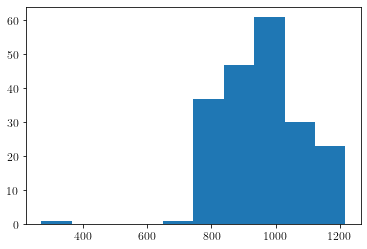

In [523]:
_=plt.hist(results[0]["z2"])

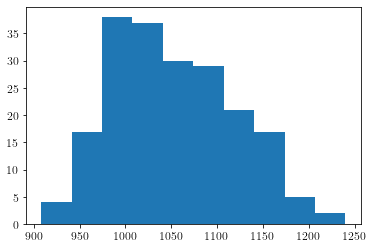

In [524]:
_=plt.hist(results[0]["z_old"])

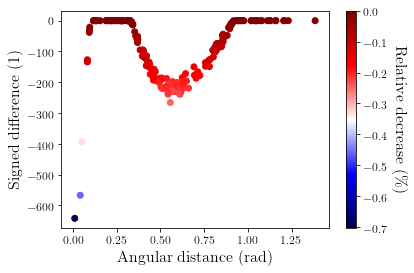

In [525]:
plt.scatter(logger.angle_gt.data, results[0]["z2"]-results[0]["z_old"], c=(results[0]["z2"]-results[0]["z_old"])/results[0]["z_old"], cmap="seismic")
# plt.title("Difference of star pairs between information fusion and the standard metric")
plt.xlabel("Angular distance (rad)")
plt.ylabel("Signed difference (1)")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Relative decrease (\%)", rotation=270)
plt.savefig("st_diff.png", bbox_inches='tight')

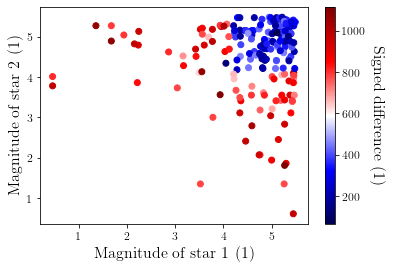

In [526]:
# plt.scatter(logger.mag1.data, logger.mag2.data, marker="x",c=z2_mag-z_old_mag, cmap="jet")
c = plt.scatter(logger.mag1.data, logger.mag2.data, marker="o", c=results[0]["z2"]-results[0]["z_old_mag"], cmap="seismic")
plt.xlabel("Magnitude of star 1 (1)")
plt.ylabel("Magnitude of star 2 (1)")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Signed difference (1)", rotation=270)
plt.savefig("st_scatter_z2_z_old_mag.png", bbox_inches='tight')

# Experimental sandbox

In [121]:
# source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [143]:
import matplotlib.colors as colors

z_color = 
def val2color(val):
    # setup a Normalization instance
    norm = colors.Normalize(val.min(),val.max())

    # define the colormap
    cmap = discrete_cmap(10, 'jet')

    # Use the norm and cmap to define the edge colours
    edgecolors = cmap(norm(val))
    
    return edgecolors


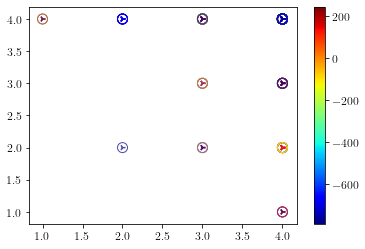

In [191]:
# plt.scatter(logger.mag1.data, logger.mag2.data, marker="o",  edgecolors="b", c="None", cmap="jet", alpha=1)
plt.scatter(sm.mag1_discrete[logger.id1.data], sm.mag2_discrete[logger.id2.data], marker="o", s=100, edgecolors=val2color(z2-z_old_mag), c="None", alpha=0.7)
plt.scatter(sm.mag1_discrete[logger.id1.data], sm.mag2_discrete[logger.id2.data], marker="4", c=val2color(z2_mag-z_old_mag),  cmap="jet", alpha=0.7)
plt.colorbar(c)

In [358]:
gain, num = sm.gain_grid(z2-z_old_mag)

avg = gain/num

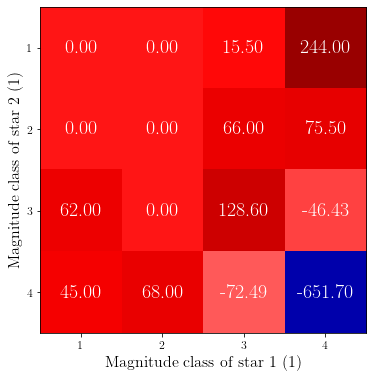

In [359]:


fig, ax = plt.subplots(figsize=(8,6))
heatmap(fig, ax, gain/num)

In [361]:


def heatmap(fig, ax, avg):
    im = ax.imshow( avg, cmap= "seismic")
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(np.arange(4)+1)
    ax.set_yticks(np.arange(4))
    ax.set_yticklabels( np.arange(4)+1)
    ax.set_xlabel("Magnitude class of star 1 (1)")
    ax.set_ylabel("Magnitude class of star 2 (1)")

    for i in range(4):
        for j in range(4):
            text = ax.text(j, i, f"{avg[i, j]:.2f}", ha="center", va="center", color="w", size=20)

#     im.set_clim(-800, 300)

#     cbar = fig.colorbar(im)
#     cbar.ax.get_yaxis().labelpad = 20
#     cbar.ax.set_ylabel("Signed difference (1)", rotation=270)

In [522]:


# végigiterálni a noise scale-n
# legenerálni z-ket
# plottolni a heatmap-et
# (esetleg ezt megcsinálni a magnitude noise-ra is) --> fontos, hogy ki legyen írva, hogy hányszor maradt bent a ground truth (ua-kal a paraméterekkel)

results = []

for n_std in sm.noise_std_scales:
    print(f"noise_std={n_std}")
    item = {}
    
    # z_old
    item["z_old"] = sm.z_old(noise_std=n_std, eps=EPS)
    item["z_old_filtered"] = sm.z_old_filtered(noise_std=n_std, eps=EPS)
    item["z_old_mag"] = sm.z_old_mag(noise_std=n_std, eps=EPS)
    
    # z2
#     item["z_new2"] = sm.z_new2(noise_std=n_std, k=K, w=W, offset=OFFSET)
    item["z_new2_filtered"] = sm.z_new2_filtered(noise_std=n_std, k=K, w=W, offset=OFFSET)
    item["z2"] = sm.z2(noise_std=n_std, k=K, w=W, offset=OFFSET, eps=EPS)
#     item["z2_mag"] = sm.z2_mag(noise_std=n_std, k=K, w=W, offset=OFFSET, eps=EPS)
    
    results.append(item)
    print((item["z_old_filtered"]==0).sum(),  (item["z_new2_filtered"]==0).sum())
    break

noise_std=0.1
0 1


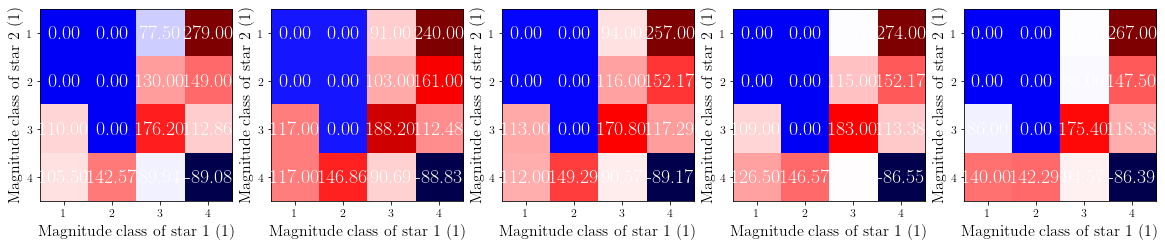

In [439]:


fig, ax = plt.subplots(1, len(sm.noise_std_scales), figsize=(20,15))

for i, (n_std, result) in enumerate(zip(sm.noise_std_scales, results)):
    gain, num = sm.gain_grid(result["z2"]-result["z_old_mag"])
    heatmap(fig, ax[i], gain/num)

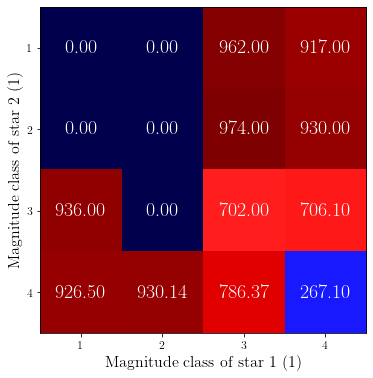

In [510]:
fig, ax = plt.subplots(figsize=(8,6))
gain, num = sm.gain_grid(results[0]["z2"]-results[0]["z_old_mag"])
heatmap(fig, ax, gain/num)

In [511]:
gain.sum()/num.sum()

469.9560975609756